In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_04 import *

importing Jupyter notebook from notebook2script_py.ipynb


## Initial setup

[Jump_to lesson 9 video](https://course19.fast.ai/videos/?lesson=9&t=7013)

In [7]:
x_train,y_train,x_valid,y_valid = get_data()
y_train = y_train.type(torch.LongTensor)
y_valid = y_valid.type(torch.LongTensor)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

In [8]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [9]:
#export
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

In [10]:
learn = create_learner(get_model, loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [0.6780896875, tensor(0.8007)]
valid: [0.312122509765625, tensor(0.9111)]
train: [0.30380400390625, tensor(0.9119)]
valid: [0.261823779296875, tensor(0.9231)]
train: [0.2486877734375, tensor(0.9280)]
valid: [0.2070280517578125, tensor(0.9426)]


In [11]:
learn = create_learner(partial(get_model, lr=0.3), loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [0.75576359375, tensor(0.8058)]
valid: [0.3507890625, tensor(0.9046)]
train: [0.3428965625, tensor(0.9022)]
valid: [0.295852685546875, tensor(0.9148)]
train: [0.2905862109375, tensor(0.9177)]
valid: [0.251711376953125, tensor(0.9295)]


In [12]:
#export
def get_model_func(lr=0.5): return partial(get_model, lr=lr)

## Annealing

We define two new callbacks: the Recorder to save track of the loss and our scheduled learning rate, and a ParamScheduler that can schedule any hyperparameter as long as it's registered in the state_dict of the optimizer. 

[Jump_to lesson 9 video](https://course19.fast.ai/videos/?lesson=9&t=7202)

In [13]:
#export
class Recorder(Callback):
    def begin_fit(self): self.lrs,self.losses = [],[]

    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_func): self.pname,self.sched_func = pname,sched_func

    def set_param(self):
        for pg in self.opt.param_groups:
            pg[self.pname] = self.sched_func(self.n_epochs/self.epochs)
            
    def begin_batch(self): 
        if self.in_train: self.set_param()

Let's start with a simple linear schedule going from start to end. It returns a function that takes a `pos` argument (going from 0 to 1) such that this function goes from `start` (at `pos=0`) to `end` (at `pos=1`) in a linear fashion.

[Jump_to lesson 9 video](https://course19.fast.ai/videos/?lesson=9&t=7431)

In [14]:
def sched_lin(start, end):
    def _inner(start, end, pos): return start + pos*(end-start)
    return partial(_inner, start, end)

We can refactor this with a decorator.

[Jump_to lesson 9 video](https://course19.fast.ai/videos/?lesson=9&t=7526)

In [15]:
#export
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)

In [16]:
# shift-tab works too, in Jupyter!
#sched_lin()

In [17]:
f = sched_lin(1,2)
f(0.3)

1.3

And here are other scheduler functions:

In [18]:
#export
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos):  return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

def cos_1cycle_anneal(start, high, end):
    return [sched_cos(start, high), sched_cos(high, end)]

#This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

[Jump_to lesson 9 video](https://course19.fast.ai/videos/?lesson=9&t=7730)

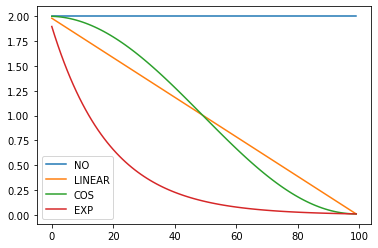

In [19]:
annealings = "NO LINEAR COS EXP".split()

a = torch.arange(0, 100)
p = torch.linspace(0.01,1,100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

In practice, we'll often want to combine different schedulers, the following function does that: it uses `scheds[i]` for `pcts[i]` of the training.

In [20]:
#export
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        if idx == 2: idx = 1
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

Here is an example: use 30% of the budget to go from 0.3 to 0.6 following a cosine, then the last 70% of the budget to go from 0.6 to 0.2, still following a cosine.

In [21]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 

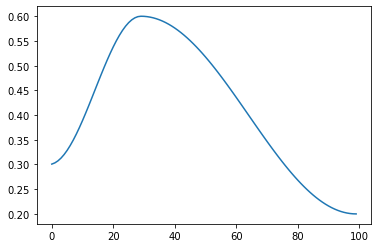

In [22]:
plt.plot(a, [sched(o) for o in p])

We can use it for training quite easily...

In [23]:
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        partial(ParamScheduler, 'lr', sched)]

In [24]:
learn = create_learner(get_model_func(0.3), loss_func, data)
run = Runner(cb_funcs=cbfs)

In [25]:
run.fit(3, learn)

train: [0.781123515625, tensor(0.7879)]
valid: [0.349321435546875, tensor(0.8949)]
train: [0.2943194921875, tensor(0.9135)]
valid: [0.232355126953125, tensor(0.9347)]
train: [0.23255744140625, tensor(0.9335)]
valid: [0.20632099609375, tensor(0.9428)]


... then check with our recorder if the learning rate followed the right schedule.

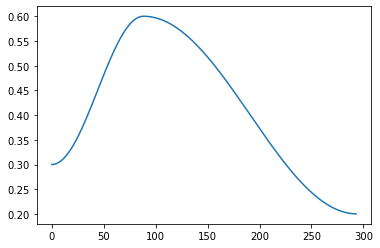

In [26]:
run.recorder.plot_lr()

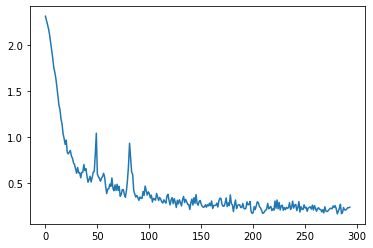

In [27]:
run.recorder.plot_loss()

# Reference for this notebook

In [ ]:
#https://github.com/fastai/course-v3/blob/master/nbs/dl2/05_anneal.ipynb